# Imports

In [ ]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# If in Google Colab, clone the repository
if IN_COLAB:
    !git clone https://github.com/alexgaarciia/SyntheticTrafficRouting.git
    import os
    os.chdir('SyntheticTrafficRouting/')
    print("Repository cloned!")
else:
    print("Not in Google Colab, skipping repository clone.")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# Load real and synthetic data

In [3]:
combined_data = pd.read_csv("real_data.csv", sep=",")
synthetic_data_sdv = pd.read_csv("synthetic_data_sdv.csv", sep=",")
synthetic_data_gan = pd.read_csv("synthetic_data_gan.csv", sep=",")

In [4]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(combined_data)

# Measure the statistical similarity between real and synthetic data

## SDV Generated Data

In [5]:
quality_report = evaluate_quality(
    combined_data,
    synthetic_data_sdv,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 3/3 [00:00<00:00, 105.94it/s]|
Column Shapes Score: 92.43%

(2/2) Evaluating Column Pair Trends: |██████████| 3/3 [00:00<00:00, 93.04it/s]|
Column Pair Trends Score: 71.4%

Overall Score (Average): 81.91%



In [6]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_sdv,
    column_name='source',
    metadata=metadata
)

fig.show()

In [7]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_sdv,
    column_name='target',
    metadata=metadata
)

fig.show()

## GAN Generated Data

In [8]:
quality_report2 = evaluate_quality(
    combined_data,
    synthetic_data_gan,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 3/3 [00:00<00:00, 181.74it/s]|
Column Shapes Score: 89.22%

(2/2) Evaluating Column Pair Trends: |██████████| 3/3 [00:00<00:00, 59.70it/s]|
Column Pair Trends Score: 81.1%

Overall Score (Average): 85.16%



In [9]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_gan,
    column_name='source',
    metadata=metadata
)

fig.show()

In [10]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_gan,
    column_name='target',
    metadata=metadata
)

fig.show()

# Link load comparison

To further extent the comparison between the real data and the synthetic data, we want to see how much does the link load (demand_value) varies between these two.

To do so, we will follow this approach:
1. For each dataset (real and synthetic), we will create a new dataset that stores, for each unique source-destination pair, the total link load. This is computed by summing up the demand value for each unique pair.
2. Calculate the absolute and relative difference in link loads.

$$
AD = |y - \hat{y}|
$$

$$
RD = \left| \frac{y - \hat{y}}{y} \right|
$$

In [11]:
# Group by source and target
real_clean = combined_data.groupby(["source", "target"])["demand_value"].sum().reset_index()
synthetic_gan_clean = synthetic_data_gan.groupby(["source", "target"])["demand_value"].sum().reset_index()
synthetic_sdv_clean = synthetic_data_sdv.groupby(["source", "target"])["demand_value"].sum().reset_index()

In [12]:
# Filter out rows with same source and destination
synthetic_gan_clean = synthetic_gan_clean[synthetic_gan_clean["source"] != synthetic_gan_clean["target"]]
synthetic_sdv_clean = synthetic_sdv_clean[synthetic_sdv_clean["source"] != synthetic_sdv_clean["target"]]

In [13]:
# Merge datasets
df_comparison_temp = pd.merge(real_clean, synthetic_gan_clean,
                         on=["source", "target"],
                         how="outer",
                         suffixes=("_real", "_gan")).fillna(0)

df_comparison = pd.merge(df_comparison_temp, synthetic_sdv_clean,
                         on=["source", "target"],
                         how="outer").fillna(0)

df_comparison.rename(columns={"demand_value": "demand_value_sdv"}, inplace=True)

In [14]:
# Calculate the absolute and relative differences
df_comparison["abs_diff_gan"] = abs(
    df_comparison["demand_value_real"] - df_comparison["demand_value_gan"])
df_comparison["rel_diff_gan"] = df_comparison["abs_diff_gan"] / df_comparison["demand_value_real"]

df_comparison["abs_diff_sdv"] = abs(
    df_comparison["demand_value_real"] - df_comparison["demand_value_sdv"])
df_comparison["rel_diff_sdv"] = df_comparison["abs_diff_sdv"] / df_comparison["demand_value_real"]

In [15]:
df_comparison

source  target  demand_value_real  demand_value_gan  demand_value_sdv  \
0    ATLAM5  ATLAng          17.534634          1.040189         97.060052   
1    ATLAM5  CHINng          75.772277         16.572740       1431.772548   
2    ATLAM5  DNVRng           9.632912         15.398446        245.916089   
3    ATLAM5  HSTNng          36.379783        226.628432        173.628859   
4    ATLAM5  IPLSng          41.337268        163.412352        139.901577   
..      ...     ...                ...               ...               ...   
127  WASHng  KSCYng        2615.030965      14810.642545       6034.963901   
128  WASHng  LOSAng       12007.106016      27626.884936       4766.882244   
129  WASHng  NYCMng       20488.272780      17294.352921       5822.724493   
130  WASHng  SNVAng         393.837527       6024.650641       1470.068881   
131  WASHng  STTLng        4527.962891       5607.947878       3365.805177   

     abs_diff_gan  rel_diff_gan  abs_diff_sdv  rel_diff_sdv  
0       16.494445      0.940678     79.525418      4.535334  
1       59.199537      0.781282   1356.000271     17.895731  
2        5.765534      0.598524    236.283177     24.528738  
3      190.248649      5.229516    137.249076      3.772674  
4      122.075084      2.953148     98.564309      2.384393  
..            ...           ...           ...           ...  
127  12195.611580      4.663659   3419.932936      1.307798  
128  15619.778920      1.300878   7240.223772      0.602995  
129   3193.919859      0.155890  14665.548287      0.715802  
130   5630.813114     14.297300   1076.231354      2.732679  
131   1079.984987      0.238515   1162.157714      0.256662  

[132 rows x 9 columns]

In [16]:
mad_gan = df_comparison['abs_diff_gan'].mean()
mrd_gan = df_comparison['rel_diff_gan'].mean()
print(f"Mean Absolute Difference (GAN): {mad_gan}")
print(f"Mean Relative Difference (GAN): {mrd_gan}")
print()

mad_sdv = df_comparison['abs_diff_sdv'].mean()
mrd_sdv = df_comparison['rel_diff_sdv'].mean()
print(f"Mean Absolute Difference (SDV): {mad_sdv}")
print(f"Mean Relative Difference (SDV): {mrd_sdv}")

Mean Absolute Difference (GAN): 3294.7232348873936
Mean Relative Difference (GAN): 5.769206010721679

Mean Absolute Difference (SDV): 1887.9232151666668
Mean Relative Difference (SDV): 2.393097584057493


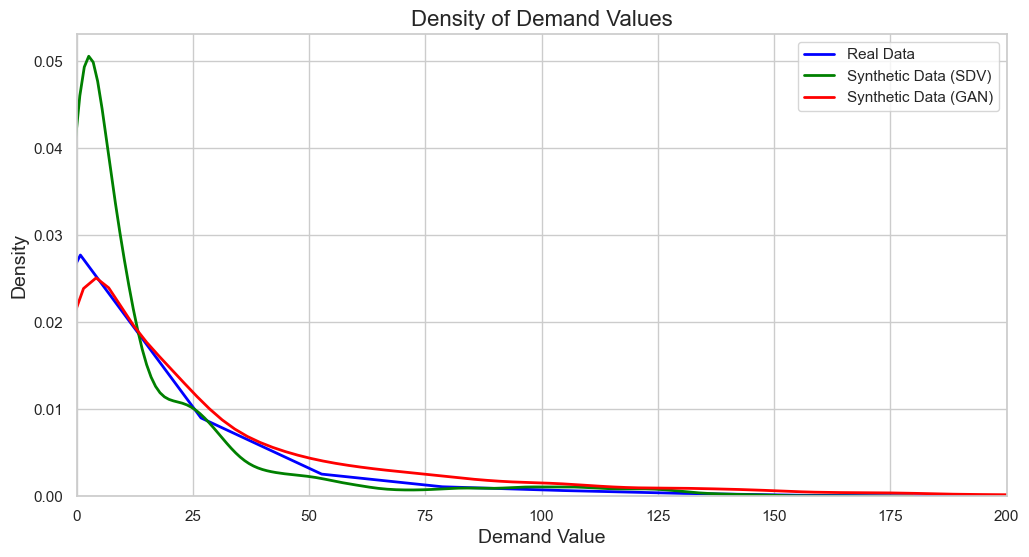

In [17]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure and axis object
plt.figure(figsize=(12, 6))

# Plot the density for 'demand_value' from real and synthetic data
sns.kdeplot(combined_data['demand_value'], color='blue', label='Real Data', linewidth=2)
sns.kdeplot(synthetic_data_sdv['demand_value'], color='green', label='Synthetic Data (SDV)', linewidth=2)
sns.kdeplot(synthetic_data_gan['demand_value'], color='red', label='Synthetic Data (GAN)', linewidth=2)

# Add labels and title
plt.xlim(0, 200)
plt.title('Density of Demand Values', fontsize=16)
plt.xlabel('Demand Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.show()

# Lowest link load comparison

In [18]:
# Group by 'source' and 'target', then get the minimum 'demand_value' for each group
min_demand_real = combined_data.loc[combined_data.groupby(['source', 'target'])['demand_value'].idxmin()]
min_demand_gan = synthetic_data_gan.loc[synthetic_data_gan.groupby(['source', 'target'])['demand_value'].idxmin()]
min_demand_sdv = synthetic_data_sdv.loc[synthetic_data_sdv.groupby(['source', 'target'])['demand_value'].idxmin()]

In [19]:
# Filter out rows with same source and destination
min_demand_gan = min_demand_gan[min_demand_gan["source"] != min_demand_gan["target"]]
min_demand_sdv = min_demand_sdv[min_demand_sdv["source"] != min_demand_sdv["target"]]

In [20]:
# Merge datasets
df_min_comparison_temp = pd.merge(min_demand_real, min_demand_gan,
                         on=["source", "target"],
                         how="outer",
                         suffixes=("_min_real", "_min_gan")).fillna(0)

df_min_comparison = pd.merge(df_min_comparison_temp, min_demand_sdv,
                         on=["source", "target"],
                         how="outer").fillna(0)

df_min_comparison.rename(columns={"demand_value": "demand_value_min_sdv"}, inplace=True)

In [21]:
# Calculate the absolute and relative differences
df_min_comparison["abs_diff_gan"] = abs(
    df_min_comparison["demand_value_min_real"] - df_min_comparison["demand_value_min_gan"])
df_min_comparison["rel_diff_gan"] = df_min_comparison["abs_diff_gan"] / df_min_comparison["demand_value_min_real"]

df_min_comparison["abs_diff_sdv"] = abs(
    df_min_comparison["demand_value_min_real"] - df_min_comparison["demand_value_min_sdv"])
df_min_comparison["rel_diff_sdv"] = df_min_comparison["abs_diff_sdv"] / df_min_comparison["demand_value_min_real"]

In [22]:
df_min_comparison

source  target  demand_value_min_real  demand_value_min_gan  \
0    ATLAM5  ATLAng               0.026667              0.013352   
1    ATLAM5  CHINng               0.026667              0.013350   
2    ATLAM5  DNVRng               0.026667              0.013965   
3    ATLAM5  HSTNng               0.026667              0.013634   
4    ATLAM5  IPLSng               0.026667              0.013453   
..      ...     ...                    ...                   ...   
127  WASHng  KSCYng               0.047872             13.664383   
128  WASHng  LOSAng               0.026667              0.162270   
129  WASHng  NYCMng               1.390976              0.359176   
130  WASHng  SNVAng               0.026667              0.443099   
131  WASHng  STTLng               0.114648              2.042275   

     demand_value_min_sdv  abs_diff_gan  rel_diff_gan  abs_diff_sdv  \
0                0.013333      0.013315      0.499295      0.013334   
1                0.013333      0.013317      0.499399      0.013334   
2                0.013333      0.012702      0.476323      0.013334   
3                0.013333      0.013033      0.488749      0.013334   
4                0.013333      0.013214      0.495510      0.013334   
..                    ...           ...           ...           ...   
127              0.013333     13.616511    284.435808      0.034539   
128              0.077842      0.135603      5.085062      0.051175   
129              1.244916      1.031800      0.741781      0.146060   
130              0.013333      0.416432     15.615995      0.013334   
131              0.013333      1.927627     16.813439      0.101315   

     rel_diff_sdv  
0        0.500019  
1        0.500019  
2        0.500019  
3        0.500019  
4        0.500019  
..            ...  
127      0.721486  
128      1.919039  
129      0.105005  
130      0.500019  
131      0.883705  

[132 rows x 9 columns]

In [23]:
mad_gan = df_min_comparison['abs_diff_gan'].mean()
mrd_gan = df_min_comparison['rel_diff_gan'].mean()
print(f"Mean Absolute Difference (GAN): {mad_gan}")
print(f"Mean Relative Difference (GAN): {mrd_gan}")
print()

mad_sdv = df_min_comparison['abs_diff_sdv'].mean()
mrd_sdv = df_min_comparison['rel_diff_sdv'].mean()
print(f"Mean Absolute Difference (SDV): {mad_sdv}")
print(f"Mean Relative Difference (SDV): {mrd_sdv}")

Mean Absolute Difference (GAN): 3.358637013697782
Mean Relative Difference (GAN): 35.30473323518556

Mean Absolute Difference (SDV): 1.5112368484848486
Mean Relative Difference (SDV): 3.0841688025916345
